In [2]:
!pip install langchain_community langchain langgraph langchain-openai openai

In [3]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [4]:
from pydantic import BaseModel, Field
from typing import List

class InputSchema(BaseModel):
    text: str = Field(..., description="Text that needs enhancement.")
    language: str = Field(..., description="Language of the text.")

class CorrectionSchema(BaseModel):
    before: str = Field(..., description="Original text.")
    after: str = Field(..., description="Corrected text.")
    explanation: str = Field(..., description="Explanation of the correction.")

class NormalizeTextCorrectionSchema(BaseModel):
    text: str = Field(..., description="The original text.")
    lang: str = Field(..., description="The language of the text.")
    corrected_normalize_text: str = Field(..., description="The corrected text after normalization.")
    normalize_corrections: List[CorrectionSchema] = Field(..., description="The list of corrections made during normalization.")

class AdvancedGrammarCorrectionSchema(BaseModel):
    normalized_text: str = Field(..., description="The original normalized text.")
    lang: str = Field(..., description="The language of the text.")
    corrected_advanced_grammar_text: str = Field(..., description="The corrected text after applying advanced grammar corrections.")
    advanced_grammar_corrections: List[CorrectionSchema] = Field(..., description="The list of corrections made for advanced grammar.")

class ClarityReadabilityTextCorrectionSchema(BaseModel):
    advanced_grammar_text: str = Field(..., description="The original text with advanced grammar.")
    lang: str = Field(..., description="The language of the text.")
    corrected_clarity_readability_text: str = Field(..., description="The corrected text after enhancing clarity and readability.")
    clarity_readability_corrections: List[CorrectionSchema] = Field(..., description="The list of corrections made to improve clarity and readability.")

class StylisticTextCorrectionSchema(BaseModel):
    clarity_readability_text: str = Field(..., description="The original text.")
    lang: str = Field(..., description="The language of the text.")
    corrected_style_text: str = Field(..., description="The corrected text after applying stylistic enhancements.")
    stylistic_corrections: List[CorrectionSchema] = Field(..., description="The list of corrections made during stylistic enhancement.")

In [5]:
from typing import Dict, TypedDict, Optional
class GraphState(TypedDict):
    text: str
    normalized_text: str
    advanced_grammar_text: str
    clarity_readability_text: str
    corrected_style_text: str
    lang: str
    normalize_corrections: List[CorrectionSchema]
    advanced_grammar_corrections: List[CorrectionSchema]
    clarity_readability_corrections: List[CorrectionSchema]
    stylistic_corrections: List[CorrectionSchema]

In [6]:
from langgraph.graph import StateGraph
workflow = StateGraph(GraphState)

In [7]:
from langchain_openai import ChatOpenAI
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

In [8]:
from langchain_core.output_parsers import JsonOutputParser

def normalize_text(state):
    json_parser = JsonOutputParser(pydantic_object=NormalizeTextCorrectionSchema)

    messages = [
        SystemMessage(content=f"You are a text normalizer for {state['lang']} texts."),
        HumanMessage(content=f"""Please correct the following text for basic grammar and punctuation errors:

        {state['text']}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    return {
        "normalized_text": parsed_result["corrected_normalize_text"],
        "normalize_corrections": parsed_result["normalize_corrections"]
    }


In [9]:
def advanced_grammar_correction(state):
    json_parser = JsonOutputParser(pydantic_object=AdvancedGrammarCorrectionSchema)

    messages = [
        SystemMessage(content=f"You are an advanced grammar and syntax corrector for {state['lang']} texts."),
        HumanMessage(content=f"""Please review the following text for advanced grammar, sentence structure, and syntactical errors:

        {state['normalized_text']}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    return {
        "advanced_grammar_text": parsed_result["corrected_advanced_grammar_text"],
        "advanced_grammar_corrections": parsed_result["advanced_grammar_corrections"]
    }


In [10]:
def clarity_readability_enhancement(state):
    json_parser = JsonOutputParser(pydantic_object=ClarityReadabilityTextCorrectionSchema)

    messages = [
        SystemMessage(content=f"You are a clarity and readability enhancer for {state['lang']} texts."),
        HumanMessage(content=f"""Please improve the following text to make it clearer and easier to understand:

        {state['advanced_grammar_text']}

        Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
        """)
    ]

    result = llm.invoke(messages)

    parsed_result = json_parser.parse(result.content)

    return {
        "clarity_readability_text": parsed_result["corrected_clarity_readability_text"],
        "clarity_readability_corrections": parsed_result["clarity_readability_corrections"]
    }


In [11]:
def stylistic_enhancement(state):
  json_parser = JsonOutputParser(pydantic_object=StylisticTextCorrectionSchema)

  messages = [
    SystemMessage(content=f"You are a stylistic enhancer for {state['lang']} texts."),
    HumanMessage(content=f"""Please improve the professional and formal fluency, tone, and consistency of the following paragraph:

    {state['clarity_readability_text']}

    Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.
    """)
  ]

  result = llm.invoke(messages)

  parsed_result = json_parser.parse(result.content)

  return {
      "corrected_style_text": parsed_result["corrected_style_text"],
      "stylistic_corrections": parsed_result["stylistic_corrections"],
  }

In [12]:
from langgraph.graph import END

workflow.add_node("normalize_text", normalize_text)
workflow.add_node("advanced_grammar_correction", advanced_grammar_correction)
workflow.add_node("clarity_readability_enhancement", clarity_readability_enhancement)
workflow.add_node("stylistic_enhancement", stylistic_enhancement)

workflow.set_entry_point("normalize_text")
workflow.add_edge('normalize_text', "advanced_grammar_correction")
workflow.add_edge('advanced_grammar_correction', "clarity_readability_enhancement")
workflow.add_edge('clarity_readability_enhancement', "stylistic_enhancement")
workflow.add_edge('stylistic_enhancement', END)

In [13]:
app = workflow.compile()

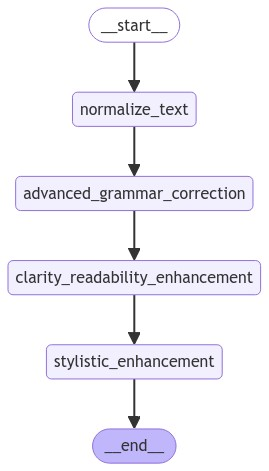

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [15]:
inputs = {
    "text": """
    bueno aki te traigo un parrafo mas largo que tiene bastantes errores de ortografia y no hay ningun tipo de acentos ni signos de puntuacion bien utilizados
    asi que la lectura se vuelve mas dificil porque las ideas no estan conectadas de forma clara por ejemplo cuando estas hablando de un tema y de repente cambias a otro
    sin siquiera poner una coma o un punto y seguido esto hace que todo el parrafo se vea muy desordenado y confuso lo que dificulta mucho entender cual es el punto principal
    que se quiere expresar
    """,
    "lang": "es"}

result = app.invoke(inputs)

In [16]:
result

{'text': '\n    bueno aki te traigo un parrafo mas largo que tiene bastantes errores de ortografia y no hay ningun tipo de acentos ni signos de puntuacion bien utilizados \n    asi que la lectura se vuelve mas dificil porque las ideas no estan conectadas de forma clara por ejemplo cuando estas hablando de un tema y de repente cambias a otro \n    sin siquiera poner una coma o un punto y seguido esto hace que todo el parrafo se vea muy desordenado y confuso lo que dificulta mucho entender cual es el punto principal \n    que se quiere expresar\n    ',
 'normalized_text': 'Bueno, aquí te traigo un párrafo más largo que tiene bastantes errores de ortografía y no hay ningún tipo de acentos ni signos de puntuación bien utilizados. Así que la lectura se vuelve más difícil porque las ideas no están conectadas de forma clara. Por ejemplo, cuando estás hablando de un tema y de repente cambias a otro sin siquiera poner una coma o un punto y seguido, esto hace que todo el párrafo se vea muy desor